In [177]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects

oregon_washington_map = gpd.read_file("BLM_OR_County_Boundaries_Polygon_Hub.shp")
oregon_map = oregon_washington_map[oregon_washington_map['COBCODE'].str[:2] == "OR"].copy()
median_county_income = pd.read_csv("county_median_income.csv")

print(oregon_map.head())
print(median_county_income.head())

  COUNTY_NAM COBCODE  ORIG_FID  \
0  JOSEPHINE   OR033        75   
1      CURRY   OR015        74   
2    JACKSON   OR029        73   
3       COOS   OR011        72   
4    KLAMATH   OR035        71   

                                            geometry  
0  POLYGON ((-123.72 42.783, -123.72 42.779, -123...  
1  POLYGON ((-124.39 42.955, -124.39 42.955, -124...  
2  POLYGON ((-122.38 42.997, -122.37 42.997, -122...  
3  POLYGON ((-124.18 43.611, -124.18 43.611, -124...  
4  POLYGON ((-121.47 43.617, -121.47 43.617, -121...  
              County   FIPS Value (Dollars) Rank within US (of 3141 counties)
0             Oregon  41000          80,426                          19 of 52
1      United States      0          78,538                               NaN
2  Washington County  41067         104,434                               115
3   Clackamas County  41005         100,360                               147
4   Deschutes County  41017          87,640                               2

In [179]:
# Normalize both data sets
oregon_map = oregon_map.rename(columns={"COUNTY_NAM": "County"})

for i in range(len(median_county_income["County"])):
    if len(median_county_income["County"].at[i].split(" ")) > 2:
        new_name = median_county_income["County"].at[i].split(" ")[:2]
        new_name = " ".join(new_name).upper()
    else:
        new_name = median_county_income["County"].at[i].split(" ")[0].upper()
    median_county_income["County"].at[i] = new_name

median_county_income = median_county_income.rename(columns={"Value (Dollars)": "Median Income"})
#print(oregon_map.head())
print(median_county_income)

        County   FIPS Median Income Rank within US (of 3141 counties)
0       OREGON  41000        80,426                          19 of 52
1       UNITED      0        78,538                               NaN
2   WASHINGTON  41067       104,434                               115
3    CLACKAMAS  41005       100,360                               147
4    DESCHUTES  41017        87,640                               297
5      YAMHILL  41071        87,084                               310
6     COLUMBIA  41009        86,359                               326
7    MULTNOMAH  41051        86,247                               330
8   HOOD RIVER  41027        82,095                               443
9        CROOK  41013        81,675                               453
10        POLK  41053        81,318                               464
11      BENTON  41003        76,011                               673
12      MARION  41047        74,624                               728
13        LINN  4104

In [181]:
# filter out counties in Washington. They came with the shapefile
washington_counties = ["ADAMS", "ASOTIN", "CHELAN", "CLALLAM", "CLARK", "COWLITZ", "FERRY", "FRANKLIN", "GARFIELD", "GRAYS HARBOR", "ISLAND", "KING", "KITSAP", "KITTITAS", "KLICKITAT", "LEWIS", "MASON", "OKANOGAN", "PACIFIC", "PEND OREILLE", "PIERCE", "SAN JUAN", "SKAGIT", "SKAMANIA", "SNOHOMISH", "SPOKANE", "STEVENS", "THURSTON", "WAHKIAKUM", "WALLA WALLA", "WHATCOM", "WHITMAN", "YAKIMA"]
oregon_map = oregon_map[~oregon_map["County"].isin(washington_counties)]

# merge the shape file with the home value index file. Similar to a SQL join.
oregon_map = oregon_map.merge(median_county_income, on="County", how="left")

In [183]:
unmatched = oregon_map[~oregon_map["County"].isin(median_county_income["County"])]
print(unmatched[["County"]])  # See which county names didn't match


Empty DataFrame
Columns: [County]
Index: []


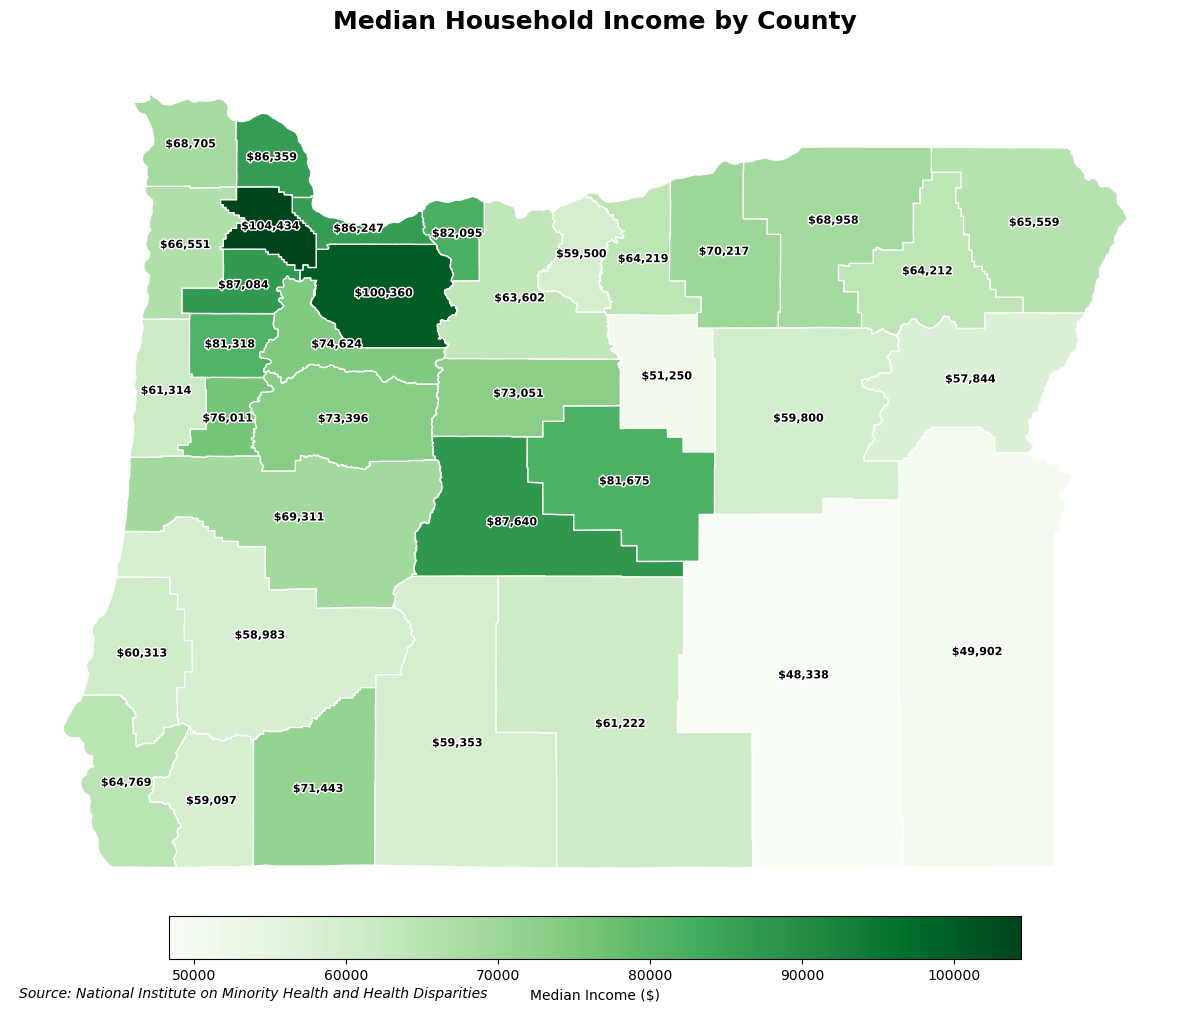

In [185]:
colors = ["#f7fcf5", "#e5f5e0", "#c7e9c0", "#a1d99b", "#74c476", "#41ab5d", "#238b45", "#006d2c", "#00441b"]
custom_cmap = LinearSegmentedColormap.from_list("custom_greens", colors)

# Convert median income column to integers
oregon_map["Median Income"] = (
    oregon_map["Median Income"]
    .astype(str)  # Ensure all values are strings before replacing
    .str.replace(",", "")  # Remove commas
    .astype(int)  # Convert to integers
)

# Calculate vmin and vmax before plotting
vmin = oregon_map['Median Income'].min()
vmax = oregon_map['Median Income'].max()

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the map with specified vmin and vmax
plot = oregon_map.plot(
    column="Median Income",
    cmap=custom_cmap,
    linewidth=1,
    edgecolor="white",
    legend=True,
    ax=ax,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={
        'label': "Median Income ($)",
        'orientation': "horizontal",
        'shrink': 0.8,
        'pad': 0.01,
        'fraction': 0.046
    }
)

# Add county labels and other styling
for idx, row in oregon_map.iterrows():
    centroid = row.geometry.centroid
    try:
        value_text = f"${int(row['Median Income']):,}"
    except ValueError:
        value_text = "$0"
    ax.text(
        centroid.x, centroid.y, value_text,
        fontsize=8, ha='center', va='center',
        fontweight='bold', color='black',
        path_effects=[PathEffects.withStroke(linewidth=2, foreground='white')]
    )

ax.set_title("Median Household Income by County", fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off()

plt.figtext(0.02, 0.02, "Source: National Institute on Minority Health and Health Disparities", fontsize=10, fontstyle='italic')
plt.tight_layout()
plt.show()